In [1]:
import pytest
import numpy as np
import pandas as pd
from inspect import signature
from altaipony.lcio import from_mast, from_path
from altaipony.altai import find_iterative_median, equivalent_duration
from altaipony.fakeflares import generate_fake_flare_distribution, aflare, mod_random, merge_fake_and_recovered_events
import copy
import progressbar
import logging
LOG = logging.getLogger(__name__)
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

#from ..fakeflares import (aflare,
#                          generate_fake_flare_distribution,
#                          merge_fake_and_recovered_events,
                         # merge_complex_flares,
                         # recovery_probability,
                         # equivalent_duration_ratio,
#                          mod_random,)


#from .test_flarelc import mock_flc

def test_mod_random():
    assert mod_random(1, d=True)[0] == pytest.approx(0.48661046)
    assert mod_random(1)[0] != mod_random(1)[0]

def test_merge_fake_and_recovered_events():

    flares = {'istart' : [5, 30],
              'istop' : [15, 36],
              'cstart' : [8, 33],
              'cstop': [18, 39],
              'tstart' : [2335.5846, 2335.5846 + 12.5/24.],
              'tstop' : [2335.5846 + 5./24., 2335.5846 + 15.5/24.],
              'ed_rec' : [650, 250],
              'ed_rec_err' : [46, 15]}
    fakes = {'duration_d' : np.linspace(0.01,1,20),
             'amplitude' : np.linspace(0.01,1,20),
             'ed_inj' : np.linspace(100,50000,20),
             'peak_time' : np.linspace(2320,2340,20),}
    flares = pd.DataFrame(flares)
    fakes = pd.DataFrame(fakes)
    tab = fakeflares.merge_fake_and_recovered_events(fakes, flares)
    print(tab)
    assert tab.size == 240
    assert tab.shape[0] == 20
    match = tab.dropna(how='any')
    assert match.shape[0] == 1
    row = match.iloc[0]
    assert row.peak_time >= row.tstart
    assert row.peak_time <= row.tstop
    assert row.ed_inj > row.ed_rec
    return match

def test_merge_fake_and_recovered_events2():
    dur, ampl = test_generate_fake_flare_distribution()
    
    return dur, ampl

def test_generate_fake_flare_distribution():

    n = 5

    dur, ampl = fakeflares.generate_fake_flare_distribution(n)
    assert (dur <= 20).all()
    assert (dur >= 1e-4).all()
    assert (ampl <= 1e2).all()
    assert (ampl >= 1e-4).all()
    assert len(dur) == n
    assert len(ampl) == n

    dur, ampl = fakeflares.generate_fake_flare_distribution(n, ampl=[1e-4, 5], dur=[0.005, 0.012],  mode='uniform')
    assert (dur <= 0.012).all()
    assert (dur >= 0.0045).all()
    assert (ampl <= 5).all()
    assert (ampl >= 1e-4).all()
    assert len(dur) == n
    assert len(ampl) == n
    
    return dur, ampl

    #n = 10
    #dur, ampl = generate_fake_flare_distribution(n, mode='loglog', d=True)
    #print(dur)
    #print(ampl)
    #assert dur[2] == pytest.approx(0.13889317143)
    #assert ampl[2] ==  pytest.approx(0.1479375816948176)
    #assert (dur <= 20).all()
    #assert (dur >= 1e-4).all()
    #assert (ampl <= 1e2).all()
    #assert (ampl >= 1e-4).all()
    #assert len(dur) == n
    #assert len(ampl) == n

def test_inject_fake_flares():
    flc = mock_flc(detrended=True)
    np.random.seed(84712)
    flc = flc.find_gaps()
    fake_flc = flc.inject_fake_flares()
    #fake_flc = inject_fake_flares(flc)
    print(fake_flc.fake_flares)
    #assert fake_flc.fake_flares.size == 20

    #columns = set(fake_flc.fake_flares.columns.values.tolist())
    #test_columns = {'amplitude', 'duration_d', 'ed_inj', 'peak_time'}
    #assert len(columns & test_columns) == 4
    #assert fake_flc.detrended_flux_err.all() >= 1e-10
    #assert fake_flc.detrended_flux.all() <= 1.
    #assert fake_flc.detrended_flux.shape == flc.detrended_flux.shape
    
    """
    flc = mock_flc(detrended=False)
    np.random.seed(84712)
    flc = flc.find_gaps()
    fake_flc = flc.inject_fake_flares()
    #fake_flc = inject_fake_flares(flc, inject_before_detrending=True)

    assert fake_flc.fake_flares.size == 20
    columns = set(fake_flc.fake_flares.columns.values.tolist())
    test_columns = {'amplitude', 'duration_d', 'ed_inj', 'peak_time'}
    assert len(columns & test_columns) == 4
    assert fake_flc.flux_err.all() >= 1e-10
    assert fake_flc.flux.all() <= 1.
    assert fake_flc.flux.shape == flc.flux.shape
    """
    return fake_flc

In [2]:
from altaipony import flarelc

def mock_flc(origin='TPF', detrended=False, ampl=1., dur=1):
    """
    Mocks a FlareLightCurve with a sinusoid variation and a single positive outlier.
    Parameter
    -----------
    origin : 'TPF' or str
        Mocks a specific origin, such as 'KLC', 'FLC' etc.
    detrended : False or bool
        If False, a sinusoid signal is added to the mock light curve.
    Return
    -------
    FlareLightCurve
    """
    n = 1000
    time = np.arange(0, n/48, 1./48.)
    pixel_time = np.outer(time,np.full((3,3), 1)).reshape((1000,3,3))
    np.random.seed(13854)

    pipeline_mask = np.array([[False, False, False],
                              [False, True,  False],
                              [False, False, False],])
    quality = np.zeros_like(time)
    np.random.seed(33)
    flux_err = np.random.rand(n)/100.
    if detrended==False:
        flux = np.sin(time/2)*7. + 500. +flux_err
        pixel_flux = np.random.rand(len(time),3,3)/100.+500.+np.sin(pixel_time/2)*7.
        pixel_flux_err = np.random.rand(len(time),3,3)/100.
    else:
        flux = 500. + flux_err
        pixel_flux = np.random.rand(len(time),3,3)/100.+500.
        pixel_flux_err = np.random.rand(len(time),3,3)/100.
    flux[15:15+dur] += 500.*ampl
    flux[15+dur:15+2*dur] += 250.*ampl
    flux[15+2*dur:15+3*dur] += 130.*ampl
    flux[15+3*dur:15+4*dur] += 80.*ampl
    quality[17] = 1024
    quality[18] = 128
    keys = {'flux' : flux, 'flux_err' : flux_err, 'time' : time,
            'pos_corr1' : np.zeros(n), 'pos_corr2' : np.zeros(n),
            'cadenceno' : np.arange(n), 'it_med' : np.full_like(time,500.005),
            'quality' : quality,}
    meta = {'targetid' : 800000000,
            'origin' : origin,  'pipeline_mask' : pipeline_mask,
            'pixel_flux' : pixel_flux, 'campaign' : 5, 'ra' : 22.,
            'dec' : 22., 'mission' : 'K2', 'channel' : 55, 
            'pixel_flux_err' : pixel_flux_err, 'time_format': 'bkjd',
            'primary_header':3, 'data_header':2}

    if detrended == False:
        flc = flarelc.FlareLightCurve(keys, meta=meta)
    else:
        keys["detrended_flux"]=flux
        keys["detrended_flux_err"]=flux_err
        flc = flarelc.FlareLightCurve(data=keys, meta=meta)
    return flc
 
flcd = test_inject_fake_flares()

   duration_d  amplitude      ed_inj  peak_time
0    0.008961   0.184924  149.616179  15.099604


In [85]:
flcdf = flcd.find_flares(N1=5, N2=4, N3=2)
flares = flcdf.flares
print(flares)

Found 77 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 23 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 11 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 6 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.


0.03542921944554189
    istart istop  cstart   cstop       tstart        tstop      ed_rec  \
0        4    12  136860  136869  2905.479392  2905.663282    3.724188   
1       18    22  136875  136880  2905.785876  2905.888037    4.899109   
2       29    33  136887  136892  2906.031063  2906.133225    4.005552   
3       39    60  136898  136921  2906.255818  2906.725760   13.671879   
4       78    85  136941  136949  2907.134405  2907.297863  102.547859   
..     ...   ...     ...     ...          ...          ...         ...   
144   3198  3200  140635  140637  2982.609108  2982.649971    0.915017   
145   3209  3211  140653  140655  2982.976879  2983.017742    1.716212   
146   3219  3223  140664  140668  2983.201628  2983.283355   12.768643   
147   3235  3237  140702  140704  2983.978035  2984.018898    3.235438   
148   3245  3247  140714  140716  2984.223216  2984.264080    6.544551   

     ed_rec_err  ampl_rec       dur  total_n_valid_data_points  
0      0.090283  0.001190 

In [86]:
print(flares.ampl_rec.max(), flares.ampl_rec.min())
print(flares.ed_rec.max(), flares.ed_rec.min())

0.03542921944554189 0.00021538126613762643
264.6833930694121 0.7146723281598526


In [4]:
def test_inject_fake_flares2():
    flc = mock_flc(detrended=True)
    np.random.seed(84712)
    flc = flc.find_gaps()
    fake_flc = flc.sample_flare_recovery(iterations=40)
    
    return fake_flc

flcd = test_inject_fake_flares2()

Found 1 candidate(s) in the (0,1000) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1000) gap.
  2%|#                                                                        |Found 2 candidate(s) in the (0,1000) gap.
  5%|###                                                                      |Found 2 candidate(s) in the (0,1000) gap.
  7%|#####                                                                    |Found 2 candidate(s) in the (0,1000) gap.
 10%|#######                                                                  |Found 2 candidate(s) in the (0,1000) gap.
 12%|#########                                                                |Found 2 candidate(s) in the (0,1000) gap.
 15%|##########                                                               |Found 2 candidate(s) in the (0,1000) gap.
 17%|############                                                             |Found 2 candidate(s) in the (0,1

#### Test on the real thing

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/lightkurve/io/kepler.py:38: ResourceWarning: unclosed file <_io.FileIO name='/Users/chris/.lightkurve-cache/mastDownload/K2/ktwo246301900-c12_lc/ktwo246301900-c12_llc.fits' mode='rb' closefd=True>
  time_format="bkjd",
7% (242/3599) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
7% (242/3599) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

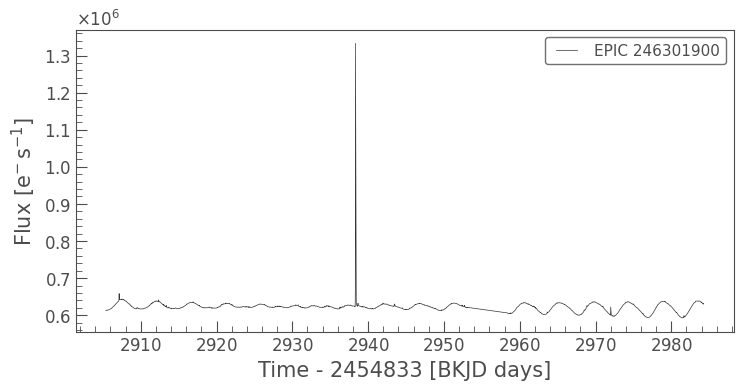

In [9]:
flc = from_mast("EPIC 246301900", mode="LC", c=12, mission="K2")
flc.plot()

In [10]:
print(flc.origin)
flc.origin = 'TPF'
print(flc.origin)
flc['data_header'] = ''
flc['primary_header'] = ''

FLC
TPF


In [11]:
flcd = flc.detrend("k2sc")

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/k2sc/dtdata.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bstarts = np.full(nblocks, -bspan, np.int)   ## Starting indices for blocks
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/k2sc/dtdata.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated 

Starting initial outlier detection at 3sigma.
  Flagged 117 ( 3.6%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    4.46 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/k2sc/de.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = np.zeros(3, np.int)


  DE iteration %3i -ln(L) %4.1f 0 -4246.165285132382
  DE iteration %3i -ln(L) %4.1f 1 -4246.165285132382
  DE iteration %3i -ln(L) %4.1f 2 -4246.165285132382
  DE iteration %3i -ln(L) %4.1f 3 -4249.704997557277
  DE iteration %3i -ln(L) %4.1f 4 -4249.704997557277
  DE iteration %3i -ln(L) %4.1f 5 -4296.792735342237
  DE iteration %3i -ln(L) %4.1f 6 -4296.792735342237
  DE iteration %3i -ln(L) %4.1f 7 -4296.792735342237
  DE iteration %3i -ln(L) %4.1f 8 -4296.792735342237
  DE iteration %3i -ln(L) %4.1f 9 -4300.92124906821
  DE iteration %3i -ln(L) %4.1f 10 -4300.92124906821
  DE iteration %3i -ln(L) %4.1f 11 -4300.92124906821
  DE iteration %3i -ln(L) %4.1f 12 -4300.92124906821
  DE iteration %3i -ln(L) %4.1f 13 -4300.92124906821
  DE iteration %3i -ln(L) %4.1f 14 -4301.886967344515
  DE iteration %3i -ln(L) %4.1f 15 -4301.886967344515
  DE iteration %3i -ln(L) %4.1f 16 -4301.886967344515
  DE iteration %3i -ln(L) %4.1f 17 -4301.886967344515
  DE iteration %3i -ln(L) %4.1f 18 -4301.88

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/k2sc/gp.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = zeros((t1.size,t2.size), np.bool)


  Local minimum found at: %s [-4.     0.501  4.643  0.018 -5.816 18.251 16.432 -3.077]


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/k2sc/gp.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = zeros((t1.size,t2.size), np.bool)


Starting final outlier detection
  %5i too high 315
  %5i too low 66
  %5i not finite 0
Computing time and position trends


De-trending successfully completed.


  CDPP - raw - %6.3f 626.3172250095157
  CDPP - position component removed - %6.3f 565.3813202950121
  CDPP - full reduction - %6.3f 349.80986205680836
Detrending time 159.13731598854065


In [333]:
def sample_flare_recovery2(lc, N1, N2, N3, iterations, fakefreq, ampl, dur, inject_before_detrending=False,
                              mode=None, func=None, save_lc_to_file=False, folder="", 
                              save=False, path=None, detrend_kwargs={},
                              **kwargs):
        """
        Runs a number of injection recovery cycles and characterizes the light
        curve by recovery probability and equivalent duration underestimation.
        Inject one flare per light curve.
        Parameters
        -----------
        iterations : 2000 or int
            Number of injection/recovery cycles
        inject_before_detrending : False or bool
            If True, fake flare are injected directly into raw data.
        mode : str
            "savgol" or "k2sc". Required if ``inject_before_detrending`` is True.
        fakefreq : 0.05 or float
            number of flares per day, but at least one per continuous observation period will be injected
        detrend_kwargs : dict
            Keyword arguments to pass to FlareLightCurve.detrend
        kwargs : dict
            Keyword arguments to pass to inject_fake_flares
        Returns
        -------
        lc : FlareLightCurve
            Detrended LC with all fake_flares listed in the attribute
        fake_lc : FlareLightCurve
            Light curve with the last iteration of synthetic flares injected.
        """
        injrecstr = {True : "before", False : "after"} # define string to identify fake flare analysis by file name
        
        #lc = copy.deepcopy(self)
        if inject_before_detrending == True:
            lc = lc.detrend(mode, func=func, **detrend_kwargs)
        lc = lc.find_gaps()
        lc = lc.find_flares(N1=N1, N2=N2, N3=N3)
        #lc = find_iterative_median(lc)
        
        lc_ = copy.deepcopy(lc)
        
        columns =  ['istart', 'istop', 'cstart', 'cstop', 'tstart', 'tstop',
                    'ed_rec', 'ed_rec_err', 'duration_d', 'amplitude', 'ed_inj',
                    'peak_time', 'ampl_rec', 'dur']
        

        widgets = [progressbar.Percentage(), progressbar.Bar()]
        bar = progressbar.ProgressBar(widgets=widgets, max_value=iterations).start()
        for i in range(iterations):
            fake_lc = inject_fake_flares2(lc, inject_before_detrending=inject_before_detrending,
                                                 fakefreq=fakefreq, ampl=ampl, dur=dur,
                                                 **kwargs)
    
            if save_lc_to_file == True:
                fake_lc.to_fits("{folder}before.fits")
                print(f"saved {self.targetit} LC before detrending")
                
            injs = fake_lc.fake_flares
           
            if inject_before_detrending == True:
                LOG.info('\nDetrending fake LC:\n')
                fake_lc = fake_lc.detrend(mode, func=func, **detrend_kwargs)
            
            fake_lc = fake_lc.find_flares(N1=N1, N2=N2, N3=N3, fake=True)
            recs = fake_lc.flares
          
            if save_lc_to_file == True:
                fake_lc.to_fits(f"{folder}after.fits")
                print(f"saved {self.targetit} LC after detrending")
                
            # The following line makes sure that column order is retained    
            injrec_results = pd.DataFrame(columns=columns)
            
            # Merge injected and recovered flares
            injrec_results = injrec_results.append(merge_fake_and_recovered_events(injs, recs),
                                                   ignore_index=True)
            

            bar.update(i + 1)
            
            if save == True:
            
                #Define default path if needed
                if path is None:
                    path = (f'{iterations}_{lc.targetid}_inj_'
                            f'{injrecstr[inject_before_detrending]}_'
                            f'{lc.campaign}.csv')
                            
                # If it already exists append new injrec to the end       
                if os.path.exists(path):
                    with open(path, 'a') as f:
                        injrec_results.to_csv(f, index=False, header=False)
                # If it doesn't then write it out but keep the header
                else:
                    injrec_results.to_csv(path, index=False)
            
            # Add to previous runs of sample_flare_recovery on the same LC or create new table    
            if lc.fake_flares.shape[0] > 0:    
                lc.fake_flares = lc.fake_flares.append(injrec_results, ignore_index=True)
            else:
                lc.fake_flares = injrec_results
                
    
        if save == True:
            # Finally read in the result                    
            lc.fake_flares = pd.read_csv(path)  

        #print(lc)
        #print(fake_lc)
        # End monitoring
        bar.finish()
        return lc, fake_lc
    
def inject_fake_flares2(fake_lc, fakefreq, ampl, dur, gapwindow=0.1,
                       inject_before_detrending=False, d=False, seed=None,
                       **kwargs):
    '''
    Create a number of events, inject them in to data
    Use grid of amplitudes and durations, keep ampl in relative flux units
    Keep track of energy in Equiv Dur.
    Duration defined in minutes
    Amplitude defined multiples of the median error
    Parameters:
    -------------
    mode : 'loglog', 'hawley2014' or 'rand'
        injection mode
    gapwindow : 0.1 or float
    fakefreq : .005 or float
        flares per day, but at least one per continuous observation period will be injected
    inject_before_detrending : True or bool
        By default, flares are injected before the light curve is detrended.
    d : boolean
        If True, a seed for random numbers will be set
    seed : int or None
        If d == True, seed will be set to this number 
    kwargs : dict
        Keyword arguments to pass to generate_fake_flare_distribution.
    Returns:
    ------------
    FlareLightCurve with fake flare signatures
    '''

    def _equivalent_duration(time, flux):
        '''
        Compute the Equivalent Duration of a fake flare.
        This is the area under the flare, in relative flux units.
        Parameters:
        -------------
        time : numpy array
            units of DAYS
        flux : numpy array
            relative flux units
        Return:
        ------------
        p : float
            equivalent duration of a single event in units of seconds
        '''
        x = time * 60.0 * 60.0 * 24.0
        integral = np.sum(np.diff(x) * flux[:-1])
        return integral


    #fake_lc = copy.deepcopy(self)
    LOG.debug(str() + '{} FakeFlares started'.format(datetime.datetime.now()))

    # Either inject flares into the un-detrended light curve
    if inject_before_detrending == True:
        typ, typerr = 'flux', 'flux_err'
        LOG.debug('Injecting before detrending.')

    # ... or into the detrended one
    elif inject_before_detrending == False:
        typ, typerr = 'detrended_flux', 'detrended_flux_err'
        LOG.debug('Injecting after detrending.')

    # How many flares do you want to inject
    # At least one per gap
    # or as defined by the frequency
    nfakesum = max(len(fake_lc.gaps),
                   int(np.rint(fakefreq *
                       (fake_lc.time.value.max() - fake_lc.time.value.min()))
                       )
                   )

    # Use a light curve where you know the median flux
    fake_lc = find_iterative_median(fake_lc)

    # Init arrays for the synthetic flare parameters
    t0_fake = np.zeros(nfakesum, dtype='float') # peak times
    ed_fake = np.zeros(nfakesum, dtype='float') # ED
    dur_fake = np.zeros(nfakesum, dtype='float') # duration
    ampl_fake = np.zeros(nfakesum, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Iterate over continuous observing periods
    for (le,ri) in fake_lc.gaps:

        # Pick the observing period
        gap_fake_lc = fake_lc[le:ri]

        # Define the number of synthetic flares you want to inject
        # minimum of 1
        nfake = max(1, int(np.rint(fakefreq *
                                   (gap_fake_lc.time.value.max() -
                                    gap_fake_lc.time.value.min()
                                   )
                                  )
                          )
                    )
        LOG.debug(f'Inject {nfake} fake flares into a {ri-le} datapoint long array.')

        # Are there real flares to deal with in the gap?
        real_flares_in_gap = fake_lc.flares[(fake_lc.flares.istart >= le) &
                                         (fake_lc.flares.istop <= ri)]

        # Pick flux, time, and flux error arrays 
        error = gap_fake_lc[typerr].value
        flux = gap_fake_lc[typ].value
        time = gap_fake_lc.time.value

        # generate the time constraints for the flares you want to inject
        mintime, maxtime = np.min(time), np.max(time)
        dtime = maxtime - mintime

        # generate a distribution of durations and amplitudes
        distribution  = generate_fake_flare_distribution(nfake, d=d,
                                                        seed=seed, 
                                                         ampl=ampl, dur=dur)
                                                         #ampl=[1e-4, 5], dur=[0.005, 0.012],
                                                         #**kwargs)
        # add the distribution for this observing period 
        # to the full list of injected flares
        dur_fake[ckm:ckm+nfake], ampl_fake[ckm:ckm+nfake] = distribution

        # loop over the numer of fake flares you want to generate
        #print(ckm, ckm+nfake)
        for k in range(ckm, ckm+nfake):

            # generate random peak time, avoid known flares
            isok = False

            # keep picking new random peak times for your synthetic flares
            # until it does not overlap with a real one
            while isok is False:

                # choose a random peak time
                # if you set a seed you will get the same synthetic flares
                # all the time
                if isinstance(seed, int):
                    t0 = (mod_random(1, d=d, seed=seed * k) * dtime + mintime)[0]

                # if you do note set a seed, the synthetic flares will be
                # randomly distributed
                elif seed is None:
                    t0 = (mod_random(1, d=d) * dtime + mintime)[0]

                # Check if there are there any real flares to deal with
                # at that peak time. Only relevant if there were any flares
                # detected at all:
                if real_flares_in_gap.tstart.shape[0] > 0:

                    # Are there any real flares happening at peak time?
                    # Fake flares should not overlap with real ones.
                    b = (real_flares_in_gap[(t0 >= real_flares_in_gap.tstart) &
                                            (t0 <= real_flares_in_gap.tstop)].
                                             shape[0] )

                    # number of flares that overlap should be 0
                    if b == 0:
                        isok = True

                # No real flares, no trouble:
                else:
                    isok = True
                
                try:
                    # add the peak time to the list
                    t0_fake[k] = t0

                    # generate the flare flux from the Davenport 2014 model
                    fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

                    # calculate the injected ED
                    ed_fake[k] = _equivalent_duration(time, fl_flux)
                
                except:
                    pass

            #print(len(fake_lc.it_med[le:ri]), len(fl_flux))
            # inject flare in to light curve by adding the flare flux
            try:
                fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
                                            fl_flux * fake_lc.it_med[le:ri].value)
            except:
                pass

        # Increment the counter
        ckm += nfake

    # error minimum is a safety net for the spline function if mode=3
    fake_lc[typerr] = max( 1e-10, np.nanmedian( pd.Series(fake_lc[typ]).
                                            rolling(3, center=True).
                                            std() ) )*np.ones_like(fake_lc[typ])
    # Put the data together
    injected_events = {'duration_d' : dur_fake,
                       'amplitude' : ampl_fake,  
                       'ed_inj' : ed_fake,
                       'peak_time' : t0_fake}

    # the fake_flares attribute is a pandas DataFrame
    fake_lc.fake_flares = pd.DataFrame(injected_events)
    #print(fake_lc.fake_flares)
    #print(fake_lc)
    
    # Free up space
    del dur_fake
    del ampl_fake

    # Return the FLC with the injected flares
    return fake_lc

In [351]:
def test_inject_fake_flares3(df, N1, N2, N3, iterations, fakefreq, ampl, dur):
    flc = df.find_gaps()
    lc, fake_flc = sample_flare_recovery2(flc, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                         ampl=ampl, dur=dur)

    #print("Before loading extra events: ", flcd.fake_flares.shape[0])
    #lc.load_injrec_data("gj1243_injrec.csv") # need more flares to more accurately assess recovery
    #print("After loading extra events: ", flcd.fake_flares.shape[0])
    
    return lc, fake_flc

N1=2
N2=2
N3=1
iterations=5
fakefreq=0.5

# find flares from actual data to get bounds on ampl and ed for fake flare generation
flcdf = flcd.find_flares(N1=N1, N2=N2, N3=N3)
flares = flcdf.flares
ampl_min = flares.ampl_rec.min()
ampl_max = flares.ampl_rec.max()
ed_min = flares.ed_rec.min()
ed_max = flares.ed_rec.max()
#lc_inj, flcd_inj = test_inject_fake_flares3(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
#                                           ampl=[ampl_min, ampl_max], dur=[ed_min, ed_max])
lc_inj, flcd_inj = test_inject_fake_flares3(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                           ampl=[0.3, 0.4], dur=[ed_min, ed_max])

Found 79 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 33 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 8 candidate(s) in the (2248,2424) gap.
Found 16 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 5 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.
Found 79 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 33 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 8 candidate(s) in the (2248,2424) gap.
Found 16 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 5 candidate(s) in the (2833,2908) gap.
Found 4 

Data flares

In [352]:
flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,4,23,136860,136881,2905.479392,2905.908470,8.909906,0.160945,0.001190,0.429078,3248.0
1,29,60,136887,136921,2906.031063,2906.725760,18.745442,0.332013,0.000676,0.694697,3248.0
2,78,85,136941,136949,2907.134405,2907.297863,102.547859,0.116507,0.029374,0.163458,3248.0
3,91,96,136956,136961,2907.440889,2907.543050,0.344166,0.007002,0.001261,0.102161,3248.0
4,104,125,136969,136992,2907.706508,2908.176449,14.052726,0.227080,0.001044,0.469941,3248.0
...,...,...,...,...,...,...,...,...,...,...,...
166,3193,3200,140630,140637,2982.506949,2982.649971,1.620239,0.137983,0.000299,0.143022,3248.0
167,3205,3213,140649,140657,2982.895152,2983.058606,2.885258,0.131851,0.000653,0.163454,3248.0
168,3219,3223,140664,140668,2983.201628,2983.283355,12.768643,0.133689,0.002118,0.081727,3248.0
169,3232,3239,140699,140707,2983.916740,2984.080194,4.147649,0.095720,0.001573,0.163454,3248.0


(array([[93.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]]), array([0.00031773, 0.00382888, 0.00734003, 0.01085117, 0.01436232,
       0.01787347, 0.02138462, 0.02489577, 0.02840692, 0.03191807,
       0.03542922]), array([  1.36567335,  27.69744532,  54.02921729,  80.36098926,
       106.69276124, 133.02453321, 159.35630518, 185.68807715,
       212.01984913, 238.3516211 , 264.68339307]), <matplotlib.collections.QuadMesh object at 0x14309ad50>)


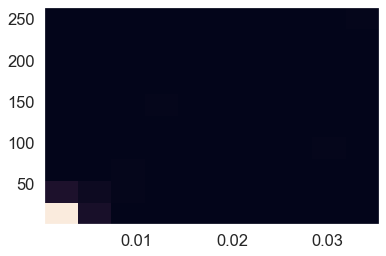

In [283]:
h = plt.hist2d(flares.ampl_rec, flares.ed_rec, bins=[10, 10])
print(h)
plt.show()

Fake flares

In [353]:
lc_inj.fake_flares.dropna()

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,duration_d,amplitude,ed_inj,peak_time,ampl_rec,dur,total_n_valid_data_points
0,771,1454,137671,138407,2922.049804,2937.087569,31548.189321,5.827056,85.492352,0.302795,434380.353467,2934.299821,0.037275,15.037765,3248.0
1,771,1454,137671,138407,2922.049804,2937.087569,31548.189321,5.827056,215.575419,0.304411,731955.056161,2927.676450,0.037275,15.037765,3248.0
2,771,1454,137671,138407,2922.049804,2937.087569,31548.189321,5.827056,153.971739,0.324264,687617.426768,2930.926850,0.037275,15.037765,3248.0
3,771,1454,137671,138407,2922.049804,2937.087569,31548.189321,5.827056,230.582983,0.394955,981447.714424,2924.921764,0.037275,15.037765,3248.0
4,771,1454,137671,138407,2922.049804,2937.087569,31548.189321,5.827056,251.992089,0.387170,849971.614139,2936.882911,0.037275,15.037765,3248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,2436,2529,139747,139848,2964.465827,2966.529413,968.317363,5.207794,237.264501,0.395838,150861.590209,2966.071158,0.009160,2.063586,3248.0
173,2767,2795,140111,140144,2971.902916,2972.577159,266.630832,3.243855,186.429684,0.340120,127607.805355,2972.557856,0.022233,0.674243,3248.0
174,2909,2955,140276,140326,2975.274133,2976.295715,904.616399,4.526163,26.983474,0.317721,53014.257775,2975.396143,0.019212,1.021582,3248.0
175,3039,3073,140434,140471,2978.502334,2979.258306,146.326398,4.067907,174.892592,0.359717,76905.329893,2978.960073,0.003538,0.755972,3248.0


In [354]:
flcd_inj.fake_flares

,duration_d,amplitude,ed_inj,peak_time
0,147.788055,0.314021,738910.577932,2910.803396
1,183.375994,0.370717,919598.896676,2916.825586
2,179.466943,0.396343,913345.730398,2928.251422
3,191.752125,0.315876,625199.846578,2937.426086
4,146.095006,0.381387,650503.624210,2938.030284
5,248.421974,0.328648,834014.449024,2911.797601
6,134.662813,0.336456,784690.248992,2911.840048
7,53.417026,0.326549,601599.801312,2915.095490
8,195.626995,0.348110,863032.559815,2921.215559
9,161.659756,0.304677,740062.149022,2914.260074


In [356]:
from altaipony.injrecanalysis import tile_up_injection_recovery

ampl_max_binning = max(ampl_max, lc_inj.fake_flares.dropna().ampl_rec.max())
ampl_min_binning = min(ampl_min, lc_inj.fake_flares.dropna().ampl_rec.min())
ampl_max_binning = 0.4
ampl_min_binning = 0.3
ed_max_binning = max(ed_max, lc_inj.fake_flares.dropna().ed_rec.max())
ed_min_binning = min(ed_min, lc_inj.fake_flares.dropna().ed_rec.min())

# Use "ed_ratio" instead of  "recovery_probability" to access the other table
dff, val = tile_up_injection_recovery(lc_inj.fake_flares, "recovery_probability", 
                                      ampl_bins=np.linspace(ampl_min_binning,ampl_max_binning,10),
                                      dur_bins=np.linspace(ed_min_binning,ed_max_binning,10))
print(dff)
print(val)

                                           rec  count
Amplitude    Duration                                
(0.3, 0.311] (-2.53, 12240.888]       0.538462     26
             (12240.888, 24484.307]        NaN      0
             (24484.307, 36727.725]        NaN      0
             (36727.725, 48971.144]        NaN      0
             (48971.144, 61214.562]        NaN      0
...                                        ...    ...
(0.389, 0.4] (48971.144, 61214.562]        NaN      0
             (61214.562, 73457.981]        NaN      0
             (73457.981, 85701.399]        NaN      0
             (85701.399, 97944.818]        NaN      0
             (97944.818, 110188.236]       NaN      0

[81 rows x 2 columns]
rec


In [357]:
print(dff['count'].sum())
print(dff['rec'].mean())

190
0.6029897690888403


In [358]:
# convert back from MultiIndex to single index
dff_rec_single_index = dff['rec'].reset_index(level=['Amplitude','Duration'])
print(dff_rec_single_index)
amp_rec_group = dff_rec_single_index.groupby(['Amplitude']).agg('mean').reset_index()
amp_rec_group['ampl_bin_left'] = amp_rec_group['Amplitude'].apply(lambda x: x.left).astype(float)
amp_rec_group['ampl_bin_right'] = amp_rec_group['Amplitude'].apply(lambda x: x.right).astype(float)
amp_rec_group['ampl_bin_mean'] = 0.5*(amp_rec_group['ampl_bin_left']+amp_rec_group['ampl_bin_right'])
print(amp_rec_group)

dur_rec_group = dff_rec_single_index.groupby(['Duration']).agg('mean').reset_index()
dur_rec_group['dur_bin_left'] = dur_rec_group['Duration'].apply(lambda x: x.left).astype(float)
dur_rec_group['dur_bin_right'] = dur_rec_group['Duration'].apply(lambda x: x.right).astype(float)
dur_rec_group['dur_bin_mean'] = 0.5*(dur_rec_group['dur_bin_left']+dur_rec_group['dur_bin_right'])

       Amplitude                 Duration       rec
0   (0.3, 0.311]       (-2.53, 12240.888]  0.538462
1   (0.3, 0.311]   (12240.888, 24484.307]       NaN
2   (0.3, 0.311]   (24484.307, 36727.725]       NaN
3   (0.3, 0.311]   (36727.725, 48971.144]       NaN
4   (0.3, 0.311]   (48971.144, 61214.562]       NaN
..           ...                      ...       ...
76  (0.389, 0.4]   (48971.144, 61214.562]       NaN
77  (0.389, 0.4]   (61214.562, 73457.981]       NaN
78  (0.389, 0.4]   (73457.981, 85701.399]       NaN
79  (0.389, 0.4]   (85701.399, 97944.818]       NaN
80  (0.389, 0.4]  (97944.818, 110188.236]       NaN

[81 rows x 3 columns]
        Amplitude       rec  ampl_bin_left  ampl_bin_right  ampl_bin_mean
0    (0.3, 0.311]  0.538462          0.300           0.311         0.3055
1  (0.311, 0.322]  0.583333          0.311           0.322         0.3165
2  (0.322, 0.333]  0.454545          0.322           0.333         0.3275
3  (0.333, 0.344]  0.647059          0.333           0.34

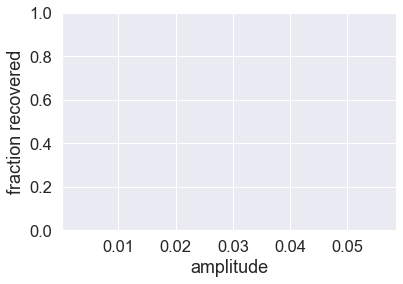

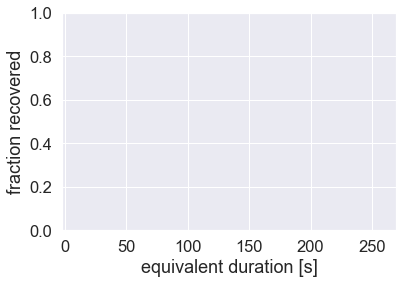

In [359]:
plt.scatter(amp_rec_group['ampl_bin_mean'], amp_rec_group['rec'])
plt.ylim(0,1)
plt.xlim(ampl_min,ampl_max)
plt.ylabel('fraction recovered')
plt.xlabel('amplitude')
plt.show()

plt.scatter(dur_rec_group['dur_bin_mean'], dur_rec_group['rec'])
plt.ylim(0,1)
plt.xlim(ed_min,ed_max)
plt.ylabel('fraction recovered')
plt.xlabel('equivalent duration [s]')
plt.show()

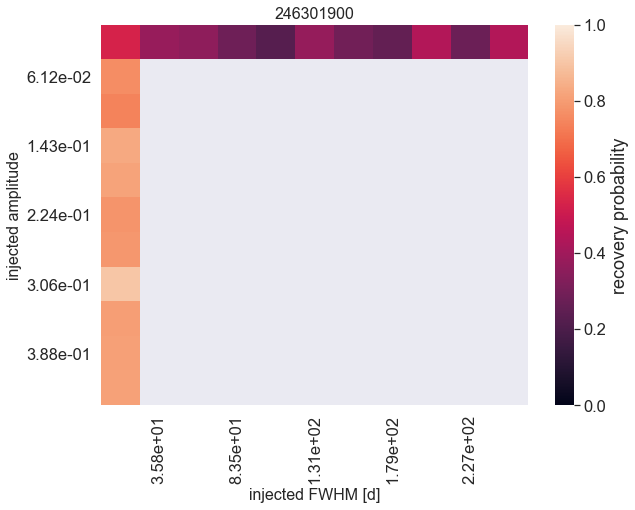

In [301]:
fig = lc_inj.plot_recovery_probability_heatmap(flares_per_bin=10)

In [224]:
lc_inj.characterize_flares(ampl_bins=10, dur_bins=10).flares


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,...,ed_corr,recovery_probability,recovery_probability_count,ed_ratio_std,amplitude_ratio_std,duration_ratio_std,recovery_probability_std,ed_corr_err,amplitude_corr_err,duration_corr_err
0,4,12,136860,136869,2905.479392,2905.663282,3.724188,0.090283,0.001190,0.183891,...,12.022739,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,1.756915e+05,364.776383,122.449817
1,18,22,136875,136880,2905.785876,2905.888037,4.899109,0.138152,0.001004,0.102161,...,15.815717,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,2.311193e+05,307.723295,68.027652
2,29,33,136887,136892,2906.031063,2906.133225,4.005552,0.149850,0.000660,0.102161,...,12.931062,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,1.889650e+05,202.473594,68.027695
3,39,60,136898,136921,2906.255818,2906.725760,13.671879,0.278613,0.000676,0.469942,...,44.136715,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,6.449816e+05,207.323817,312.926920
4,78,85,136941,136949,2907.134405,2907.297863,102.547859,0.116507,0.029374,0.163458,...,331.053664,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,4.837775e+06,9005.838758,108.844040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,3194,3200,140631,140637,2982.527381,2982.649971,1.387893,0.123751,0.000299,0.122590,...,4.480515,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,6.547495e+04,91.605259,81.631025
177,3205,3213,140649,140657,2982.895152,2983.058606,2.885258,0.131851,0.000653,0.163454,...,9.314433,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,1.361143e+05,200.197422,108.841402
178,3219,3223,140664,140668,2983.201628,2983.283355,12.768643,0.133689,0.002118,0.081727,...,41.220811,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,6.023707e+05,649.417894,54.420646
179,3232,3237,140699,140704,2983.916740,2984.018898,3.482425,0.080864,0.001573,0.102159,...,11.242257,0.335766,137.0,14613.266346,264017.603945,5.273734,0.473991,1.642861e+05,482.388611,68.025866


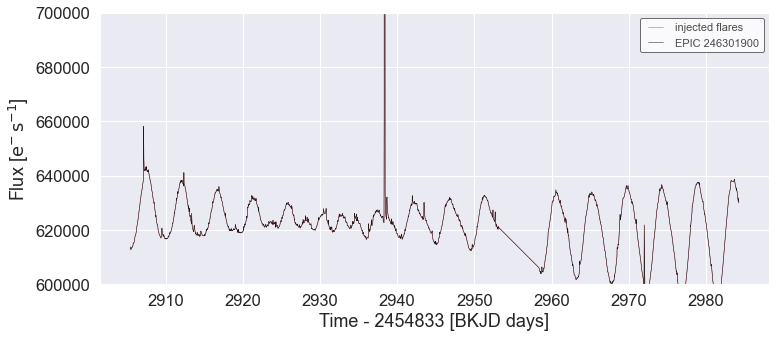

In [322]:
fig, ax = plt.subplots(figsize=(12,5))
flcd_inj.plot(ax=ax, c="r", label="injected flares")
flc.plot(ax=ax, c="k")
plt.ylim(0.6e6, 0.7e6)
plt.show()

[0.00170145 0.04538095 0.08906046 0.13273996 0.17641946 0.22009896
 0.26377846 0.30745796 0.35113747 0.39481697 0.43849647] [175 156  93 115  95 101  78  60  27  14]


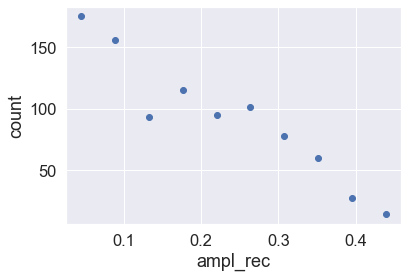

In [325]:
hist, bins = np.histogram(np.array(lc_inj.fake_flares.ampl_rec.dropna()), bins=10)
print(bins, hist)
plt.scatter(bins[1:], hist)
plt.xlabel('ampl_rec')
plt.ylabel('count')
plt.show()

[2.21187615e+00 4.29942095e+02 8.57672314e+02 1.28540253e+03
 1.71313275e+03 2.14086297e+03 2.56859319e+03 2.99632341e+03
 3.42405363e+03 3.85178385e+03 4.27951407e+03 4.70724428e+03
 5.13497450e+03 5.56270472e+03 5.99043494e+03 6.41816516e+03
 6.84589538e+03 7.27362560e+03 7.70135582e+03 8.12908604e+03
 8.55681625e+03 8.98454647e+03 9.41227669e+03 9.84000691e+03
 1.02677371e+04 1.06954673e+04 1.11231976e+04 1.15509278e+04
 1.19786580e+04 1.24063882e+04 1.28341184e+04 1.32618487e+04
 1.36895789e+04 1.41173091e+04 1.45450393e+04 1.49727695e+04
 1.54004998e+04 1.58282300e+04 1.62559602e+04 1.66836904e+04
 1.71114206e+04 1.75391509e+04 1.79668811e+04 1.83946113e+04
 1.88223415e+04 1.92500717e+04 1.96778019e+04 2.01055322e+04
 2.05332624e+04 2.09609926e+04 2.13887228e+04 2.18164530e+04
 2.22441833e+04 2.26719135e+04 2.30996437e+04 2.35273739e+04
 2.39551041e+04 2.43828344e+04 2.48105646e+04 2.52382948e+04
 2.56660250e+04 2.60937552e+04 2.65214854e+04 2.69492157e+04
 2.73769459e+04 2.780467

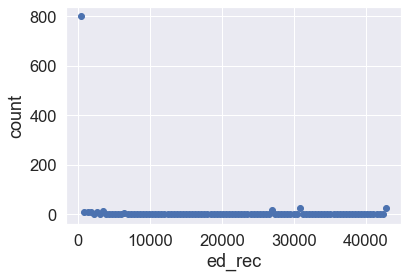

In [327]:
hist, bins = np.histogram(np.array(lc_inj.fake_flares.ed_rec.dropna()), bins=100)
print(bins, hist)
plt.scatter(bins[1:], hist)
plt.xlabel('ed_rec')
plt.ylabel('count')
plt.show()

### Compare multiple models

Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.


0.00018882018886223761 0.03542921944554189 0.9048566324560336 264.98411650529584


Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 7 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 4 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 9 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 5 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 1.1436305623634944 264.98411650529584


Found 59 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 22 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 6 candidate(s) in the (2424,2629) gap.
Found 9 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 3 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0002679329612516046 0.03542921944554189 1.3519162606658002 264.6833930694121


Found 56 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 9 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 3 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0003096236663373553 0.03542921944554189 1.596127982088145 264.6833930694121


Found 53 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 22 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 8 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 2 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 7 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.000495187749822934 0.03542921944554189 2.2863956289664134 264.6833930694121


Found 46 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 18 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 7 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.000599399862647676 0.03542921944554189 2.9681605551233567 263.9726966549993


Found 39 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 16 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 7 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 5 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0006509540313555107 0.03542921944554189 3.2076480520311987 263.9726966549993


Found 32 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 16 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

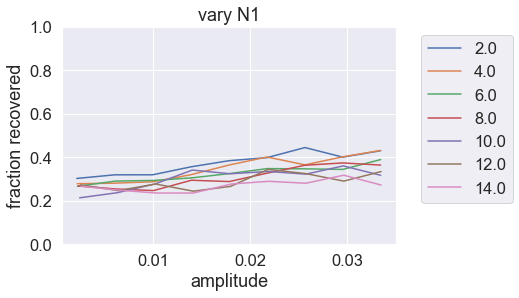

     N1  mean_rec_frac
0   2.0       0.373086
1   4.0       0.348222
2   6.0       0.323435
3   8.0       0.309132
4  10.0       0.303289
5  12.0       0.289228
6  14.0       0.269509


In [375]:
def test_inject_fake_flares_loop(df, N1, N2, N3, iterations, fakefreq, ampl, dur):
    flc = df.find_gaps()
    lc, fake_flc = sample_flare_recovery2(flc, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                         ampl=ampl, dur=dur)

    #print("Before loading extra events: ", flcd.fake_flares.shape[0])
    #lc.load_injrec_data("gj1243_injrec.csv") # need more flares to more accurately assess recovery
    #print("After loading extra events: ", flcd.fake_flares.shape[0])
    
    return lc, fake_flc

recs = []
N1s = np.linspace(2, 14, 7)
for N1 in N1s:
    N2=2
    N3=3
    iterations=50
    fakefreq=1.

    # find flares from actual data to get bounds on ampl and ed for fake flare generation
    flcdf = flcd.find_flares(N1=N1, N2=N2, N3=N3)
    flares = flcdf.flares
    
    # inject synthetic flares
    ampl_min = flares.ampl_rec.min()
    ampl_max = flares.ampl_rec.max()
    ed_min = flares.ed_rec.min()
    ed_max = flares.ed_rec.max()
    print(ampl_min, ampl_max, ed_min, ed_max)
    lc_inj, flcd_inj = test_inject_fake_flares_loop(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                               ampl=[ampl_min, ampl_max], dur=[ed_min, ed_max])
    
    # analyze recovery
    dff, val = tile_up_injection_recovery(lc_inj.fake_flares, "recovery_probability", 
                                          ampl_bins=np.linspace(ampl_min,ampl_max,10),
                                          dur_bins=np.linspace(ed_min,ed_max,10))
                                          #ampl_bins=np.linspace(0,.1,10),
                                      #dur_bins=np.linspace(0,.01,10))
                                          
    
    # convert back from MultiIndex to single index
    dff_rec_single_index = dff['rec'].reset_index(level=['Amplitude','Duration'])
    #print(dff_rec_single_index)
    amp_rec_group = dff_rec_single_index.groupby(['Amplitude']).agg('mean').reset_index()
    amp_rec_group['ampl_bin_left'] = amp_rec_group['Amplitude'].apply(lambda x: x.left).astype(float)
    amp_rec_group['ampl_bin_right'] = amp_rec_group['Amplitude'].apply(lambda x: x.right).astype(float)
    amp_rec_group['ampl_bin_mean'] = 0.5*(amp_rec_group['ampl_bin_left']+amp_rec_group['ampl_bin_right'])
    #print(amp_rec_group)

    """
    dur_rec_group = dff_rec_single_index.groupby(['Duration']).agg('mean').reset_index()
    dur_rec_group['dur_bin_left'] = dur_rec_group['Duration'].apply(lambda x: x.left).astype(float)
    dur_rec_group['dur_bin_right'] = dur_rec_group['Duration'].apply(lambda x: x.right).astype(float)
    dur_rec_group['dur_bin_mean'] = 0.5*(dur_rec_group['dur_bin_left']+dur_rec_group['dur_bin_right'])
    """
    
    plt.plot(amp_rec_group['ampl_bin_mean'], amp_rec_group['rec'], label=f"{N1}")
    recs.append(dff['rec'].mean())
    
    """
    plt.scatter(dur_rec_group['dur_bin_mean'], dur_rec_group['rec'])
    plt.ylim(0,1)
    plt.xlim(ed_min,ed_max)
    plt.ylabel('fraction recovered')
    plt.xlabel('equivalent duration [s]')
    plt.show()
    """
plt.ylim(0,1)
#plt.xlim(ampl_min,ampl_max)
plt.ylabel('fraction recovered')
plt.xlabel('amplitude')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('vary N1')
plt.show()

# read per N1 means to table!
recs_df = pd.DataFrame({'N1': N1s, 'mean_rec_frac': recs})
print(recs_df)


Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.


0.00018882018886223761 0.03542921944554189 0.9048566324560336 264.98411650529584


Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 5 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 3 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 1.1436305623634944 264.98411650529584


Found 59 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 22 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 6 candidate(s) in the (2424,2629) gap.
Found 9 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 3 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 8 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 7 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 6 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0002679329612516046 0.03542921944554189 1.3519162606658002 264.6833930694121


Found 56 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 9 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 8 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0003096236663373553 0.03542921944554189 1.596127982088145 264.6833930694121


Found 53 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 22 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 8 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 2 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.000495187749822934 0.03542921944554189 2.2863956289664134 264.6833930694121


Found 46 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 18 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 7 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 2 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 6 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.000599399862647676 0.03542921944554189 2.9681605551233567 263.9726966549993


Found 39 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 16 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 7 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 2 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0006509540313555107 0.03542921944554189 3.2076480520311987 263.9726966549993


Found 32 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 16 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 4 candidate(s) in the (0,1512

Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 0 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 0 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

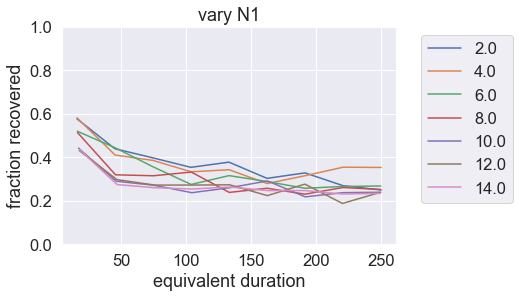

     N1  mean_rec_frac
0   2.0       0.366418
1   4.0       0.372989
2   6.0       0.332345
3   8.0       0.302301
4  10.0       0.276482
5  12.0       0.274977
6  14.0       0.271950


In [376]:
def test_inject_fake_flares_loop(df, N1, N2, N3, iterations, fakefreq, ampl, dur):
    flc = df.find_gaps()
    lc, fake_flc = sample_flare_recovery2(flc, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                         ampl=ampl, dur=dur)

    #print("Before loading extra events: ", flcd.fake_flares.shape[0])
    #lc.load_injrec_data("gj1243_injrec.csv") # need more flares to more accurately assess recovery
    #print("After loading extra events: ", flcd.fake_flares.shape[0])
    
    return lc, fake_flc

recs = []
N1s = np.linspace(2, 14, 7)
for N1 in N1s:
    N2=2
    N3=3
    iterations=50
    fakefreq=1.

    # find flares from actual data to get bounds on ampl and ed for fake flare generation
    flcdf = flcd.find_flares(N1=N1, N2=N2, N3=N3)
    flares = flcdf.flares
    
    # inject synthetic flares
    ampl_min = flares.ampl_rec.min()
    ampl_max = flares.ampl_rec.max()
    ed_min = flares.ed_rec.min()
    ed_max = flares.ed_rec.max()
    print(ampl_min, ampl_max, ed_min, ed_max)
    lc_inj, flcd_inj = test_inject_fake_flares_loop(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                               ampl=[ampl_min, ampl_max], dur=[ed_min, ed_max])
    
    # analyze recovery
    dff, val = tile_up_injection_recovery(lc_inj.fake_flares, "recovery_probability", 
                                          ampl_bins=np.linspace(ampl_min,ampl_max,10),
                                          dur_bins=np.linspace(ed_min,ed_max,10))
                                          #ampl_bins=np.linspace(0,.1,10),
                                      #dur_bins=np.linspace(0,.01,10))
                                          
    
    # convert back from MultiIndex to single index
    dff_rec_single_index = dff['rec'].reset_index(level=['Amplitude','Duration'])
    
    dur_rec_group = dff_rec_single_index.groupby(['Duration']).agg('mean').reset_index()
    dur_rec_group['dur_bin_left'] = dur_rec_group['Duration'].apply(lambda x: x.left).astype(float)
    dur_rec_group['dur_bin_right'] = dur_rec_group['Duration'].apply(lambda x: x.right).astype(float)
    dur_rec_group['dur_bin_mean'] = 0.5*(dur_rec_group['dur_bin_left']+dur_rec_group['dur_bin_right'])

    plt.plot(dur_rec_group['dur_bin_mean'], dur_rec_group['rec'], label=f"{N1}")
    recs.append(dff['rec'].mean())
    
plt.ylim(0,1)
plt.ylabel('fraction recovered')
plt.xlabel('equivalent duration')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('vary N1')
plt.show()

# read per N1 means to table!
recs_df = pd.DataFrame({'N1': N1s, 'mean_rec_frac': recs})
print(recs_df)


Found 73 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 24 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 8 candidate(s) in the (2424,2629) gap.
Found 11 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 6 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.


0.000138312329753143 0.03542921944554189 0.8891185344372055 264.98411650529584


Found 73 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 24 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 8 candidate(s) in the (2424,2629) gap.
Found 11 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 6 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in 

Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 7 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 6 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 8 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00018882018886223761 0.03542921944554189 0.9048566324560336 264.98411650529584


Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 5 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 5 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0002263741170644984 0.03542921944554189 1.586280592042372 264.98411650529584


Found 50 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 19 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 3 candidate(s) in the (0,1512

Found 3 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 5 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 2.109491950911799 264.98411650529584


Found 44 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 17 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 4 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 2.1627070217768893 264.98411650529584


Found 41 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 15 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0005447339872686197 0.03542921944554189 3.527140677207153 264.98411650529584


Found 34 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 12 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 5 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

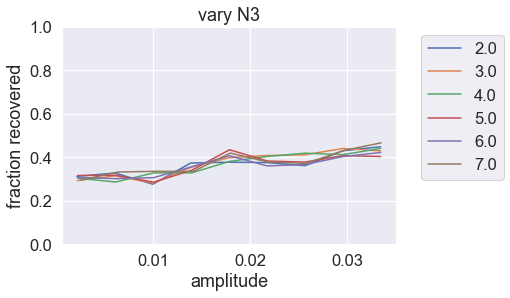

    N3  mean_rec_frac
0  2.0       0.364929
1  3.0       0.370288
2  4.0       0.367155
3  5.0       0.363084
4  6.0       0.359249
5  7.0       0.373965


In [377]:
N3s = np.linspace(2, 7, 6)
recs = []
for N3 in N3s:
    N1=3
    N2=2
    iterations=50
    fakefreq=1.

    # find flares from actual data to get bounds on ampl and ed for fake flare generation
    flcdf = flcd.find_flares(N1=N1, N2=N2, N3=N3)
    flares = flcdf.flares
    
    # inject synthetic flares
    ampl_min = flares.ampl_rec.min()
    ampl_max = flares.ampl_rec.max()
    ed_min = flares.ed_rec.min()
    ed_max = flares.ed_rec.max()
    print(ampl_min, ampl_max, ed_min, ed_max)
    lc_inj, flcd_inj = test_inject_fake_flares_loop(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                               ampl=[ampl_min, ampl_max], dur=[ed_min, ed_max])
    
    # analyze recovery
    dff, val = tile_up_injection_recovery(lc_inj.fake_flares, "recovery_probability", 
                                          ampl_bins=np.linspace(ampl_min,ampl_max,10),
                                          dur_bins=np.linspace(ed_min,ed_max,10))
                                          #ampl_bins=np.linspace(0,.1,10),
                                      #dur_bins=np.linspace(0,.01,10))
                                          
    
    # convert back from MultiIndex to single index
    dff_rec_single_index = dff['rec'].reset_index(level=['Amplitude','Duration'])
    #print(dff_rec_single_index)
    amp_rec_group = dff_rec_single_index.groupby(['Amplitude']).agg('mean').reset_index()
    amp_rec_group['ampl_bin_left'] = amp_rec_group['Amplitude'].apply(lambda x: x.left).astype(float)
    amp_rec_group['ampl_bin_right'] = amp_rec_group['Amplitude'].apply(lambda x: x.right).astype(float)
    amp_rec_group['ampl_bin_mean'] = 0.5*(amp_rec_group['ampl_bin_left']+amp_rec_group['ampl_bin_right'])
    #print(amp_rec_group)

    """
    dur_rec_group = dff_rec_single_index.groupby(['Duration']).agg('mean').reset_index()
    dur_rec_group['dur_bin_left'] = dur_rec_group['Duration'].apply(lambda x: x.left).astype(float)
    dur_rec_group['dur_bin_right'] = dur_rec_group['Duration'].apply(lambda x: x.right).astype(float)
    dur_rec_group['dur_bin_mean'] = 0.5*(dur_rec_group['dur_bin_left']+dur_rec_group['dur_bin_right'])
    """
    
    plt.plot(amp_rec_group['ampl_bin_mean'], amp_rec_group['rec'], label=f"{N3}")
    recs.append(dff['rec'].mean())
    
    """
    plt.scatter(dur_rec_group['dur_bin_mean'], dur_rec_group['rec'])
    plt.ylim(0,1)
    plt.xlim(ed_min,ed_max)
    plt.ylabel('fraction recovered')
    plt.xlabel('equivalent duration [s]')
    plt.show()
    """
plt.ylim(0,1)
#plt.xlim(ampl_min,ampl_max)
plt.ylabel('fraction recovered')
plt.xlabel('amplitude')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('vary N3')
plt.show()

# read per N3 means to table
recs_df = pd.DataFrame({'N3': N3s, 'mean_rec_frac': recs})
print(recs_df)


Found 73 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 24 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 8 candidate(s) in the (2424,2629) gap.
Found 11 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 6 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.


0.000138312329753143 0.03542921944554189 0.8891185344372055 264.98411650529584


Found 73 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 24 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 8 candidate(s) in the (2424,2629) gap.
Found 11 candidate(s) in the (2629,2833) gap.
Found 3 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 6 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 2 candidate(s) in the (3203,3224) gap.
Found 2 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 12 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 2 candidate(s) in the (1512,1537) gap.
Found 10 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 3 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 7 candidate(s) in the (0,151

Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in 

 68%|#################################################                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 3 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 6 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424

Found 2 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 4 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 5 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00018882018886223761 0.03542921944554189 0.9048566324560336 264.98411650529584


Found 61 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 21 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 7 candidate(s) in the (2248,2424) gap.
Found 7 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 5 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 3 candidate(s) in the (1537,2178) gap.
Found 3 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 5 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 3 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 5 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424

Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 7 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0002263741170644984 0.03542921944554189 1.586280592042372 264.98411650529584


Found 50 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 19 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 5 candidate(s) in the (2424,2629) gap.
Found 10 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 1 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in 

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 2 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 1 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 1 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 2.109491950911799 264.98411650529584


Found 44 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 17 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 4 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 2 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 1 candidate(s) in the (2248,2424) gap.
Found 2 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 3 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.00024441547669318275 0.03542921944554189 2.1627070217768893 264.98411650529584


Found 41 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 15 candidate(s) in the (1537,2178) gap.
Found 2 candidate(s) in the (2178,2248) gap.
Found 6 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 6 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 2 candidate(s) in the (2908,3004) gap.
Found 4 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 4 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in t

Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 4 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 4 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 9 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 2 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

0.0005447339872686197 0.03542921944554189 3.527140677207153 264.98411650529584


Found 34 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 12 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 5 candidate(s) in the (2248,2424) gap.
Found 4 candidate(s) in the (2424,2629) gap.
Found 5 candidate(s) in the (2629,2833) gap.
Found 2 candidate(s) in the (2833,2908) gap.
Found 1 candidate(s) in the (2908,3004) gap.
Found 3 candidate(s) in the (3014,3128) gap.
Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
N/A%|                                                                         |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424) gap.
Found 0 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in t

Found 1 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 22%|################                                                         |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 24%|#################                                                        |Found 1 candidate(s) in the (0,1512

Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 46%|#################################                                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in 

 68%|#################################################                        |Found 2 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 2 candidate(s) in the (1537,2178) gap.
Found 1 candidate(s) in the (2178,2248) gap.
Found 2 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 1 candidate(s) in the (2629,2833) gap.
Found 1 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 70%|###################################################                      |Found 3 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 1 candidate(s) in the (2248,2424

Found 0 candidate(s) in the (2908,3004) gap.
Found 0 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 92%|###################################################################      |Found 1 candidate(s) in the (0,1512) gap.
Found 1 candidate(s) in the (1512,1537) gap.
Found 1 candidate(s) in the (1537,2178) gap.
Found 0 candidate(s) in the (2178,2248) gap.
Found 3 candidate(s) in the (2248,2424) gap.
Found 1 candidate(s) in the (2424,2629) gap.
Found 2 candidate(s) in the (2629,2833) gap.
Found 0 candidate(s) in the (2833,2908) gap.
Found 0 candidate(s) in the (2908,3004) gap.
Found 1 candidate(s) in the (3014,3128) gap.
Found 0 candidate(s) in the (3132,3181) gap.
Found 0 candidate(s) in the (3186,3203) gap.
Found 0 candidate(s) in the (3203,3224) gap.
Found 0 candidate(s) in the (3229,3248) gap.
 94%|###################

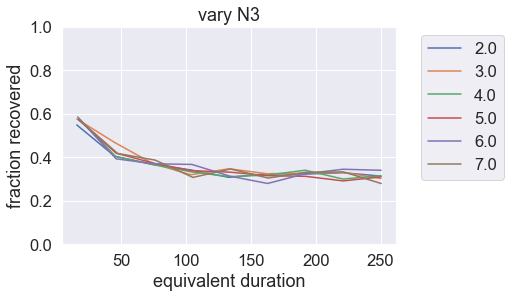

    N3  mean_rec_frac
0  2.0       0.362303
1  3.0       0.374127
2  4.0       0.363865
3  5.0       0.362895
4  6.0       0.368304
5  7.0       0.364055


In [378]:
N3s = np.linspace(2, 7, 6)
recs = []
for N3 in N3s:
    N1=3
    N2=2
    iterations=50
    fakefreq=1.

    # find flares from actual data to get bounds on ampl and ed for fake flare generation
    flcdf = flcd.find_flares(N1=N1, N2=N2, N3=N3)
    flares = flcdf.flares
    
    # inject synthetic flares
    ampl_min = flares.ampl_rec.min()
    ampl_max = flares.ampl_rec.max()
    ed_min = flares.ed_rec.min()
    ed_max = flares.ed_rec.max()
    print(ampl_min, ampl_max, ed_min, ed_max)
    lc_inj, flcd_inj = test_inject_fake_flares_loop(flcd, N1=N1, N2=N2, N3=N3, iterations=iterations, fakefreq=fakefreq,
                                               ampl=[ampl_min, ampl_max], dur=[ed_min, ed_max])
    
    # analyze recovery
    dff, val = tile_up_injection_recovery(lc_inj.fake_flares, "recovery_probability", 
                                          ampl_bins=np.linspace(ampl_min,ampl_max,10),
                                          dur_bins=np.linspace(ed_min,ed_max,10))
                                          #ampl_bins=np.linspace(0,.1,10),
                                      #dur_bins=np.linspace(0,.01,10))
                                          
    
    # convert back from MultiIndex to single index
    dff_rec_single_index = dff['rec'].reset_index(level=['Amplitude','Duration'])
    
    dur_rec_group = dff_rec_single_index.groupby(['Duration']).agg('mean').reset_index()
    dur_rec_group['dur_bin_left'] = dur_rec_group['Duration'].apply(lambda x: x.left).astype(float)
    dur_rec_group['dur_bin_right'] = dur_rec_group['Duration'].apply(lambda x: x.right).astype(float)
    dur_rec_group['dur_bin_mean'] = 0.5*(dur_rec_group['dur_bin_left']+dur_rec_group['dur_bin_right'])

    plt.plot(dur_rec_group['dur_bin_mean'], dur_rec_group['rec'], label=f"{N3}")
    recs.append(dff['rec'].mean())
    
plt.ylim(0,1)
plt.ylabel('fraction recovered')
plt.xlabel('equivalent duration')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('vary N3')
plt.show()

# read per N3 means to table
recs_df = pd.DataFrame({'N3': N3s, 'mean_rec_frac': recs})
print(recs_df)

### With the Altaipony + FINDflare() method

In [20]:
flux_diff = flcd.detrended_flux / np.nanmedian(flcd.detrended_flux) - 1
error = flcd.detrended_flux_err / np.nanmedian(flcd.detrended_flux_err) - 1

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


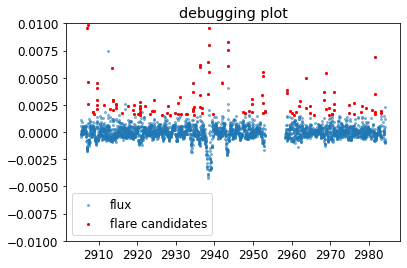

In [23]:
gapwindow = 0.1
minsep = 3
import appaloosa_snippets.appaloosa as appaloosa

# run final flare-find on DATA - MODEL
isflare = appaloosa.FINDflare(flux_diff, error, N1=5, N2=4, N3=1, # setting N3=1 is risky for FPs, but there's at least one flare we're missing without it
                    returnbinary=True, avg_std=True, std_window=7)

# now pick out final flare candidate points from above
cand1 = np.where(isflare > 0)[0]

time = flcd.time.value #lc.TIME
#time = np.array(time)
x1 = np.where((np.abs(time[cand1]-time[-1]) < gapwindow))
x2 = np.where((np.abs(time[cand1]-time[0]) < gapwindow))
cand1 = np.delete(cand1, x1)
cand1 = np.delete(cand1, x2)
if (len(cand1) < 1):
    istart_i = np.array([])
    istop_i = np.array([])
else:
    # find start and stop index, combine neighboring candidates in to same events
    istart_i = cand1[np.append([0], np.where((cand1[1:]-cand1[:-1] > minsep))[0]+1)]
    istop_i = cand1[np.append(np.where((cand1[1:]-cand1[:-1] > minsep))[0], [len(cand1)-1])]
# if start & stop times are the same, add 1 more datum on the end
to1 = np.where((istart_i-istop_i == 0))
if len(to1[0])>0:
    istop_i[to1] += 1

#print(flux_model_i)
plt.figure()
plt.title('debugging plot')
#plt.scatter(time, norm_flux, alpha=0.5,label='flux', s=15)
plt.scatter(flcd.time.value, flux_diff, alpha=0.5,label='flux', s=4)
#plt.plot(time,flux_model_i+np.nanmedian(lc.PDCSAP_FLUX), c='black',label='flux model')
#plt.scatter(time[cand1], np.array(norm_flux)[cand1], c='red',label='flare candidates', s=15)
plt.scatter(flcd.time.value[cand1], np.array(flux_diff)[cand1], c='red',label='flare candidates', s=4)
#plt.xlim(2935, 2938) # 2970, 2975
plt.ylim(-0.01, 0.01)
plt.legend()
plt.show()

In [38]:
cand1

array([  78,   79,   80,   81,   82,  140,  141,  150,  184,  185,  186,
        187,  188,  270,  350,  364,  378,  379,  380,  381,  420,  421,
        422,  488,  568,  630,  631,  632,  681,  704,  705,  706,  707,
        708,  709,  710,  712,  771,  831,  856,  873,  880,  968, 1034,
       1047, 1064, 1127, 1155, 1156, 1183, 1195, 1251, 1263, 1335, 1336,
       1337, 1338, 1351, 1352, 1417, 1418, 1419, 1420, 1445, 1446, 1510,
       1511, 1512, 1513, 1514, 1519, 1520, 1521, 1563, 1665, 1733, 1734,
       1735, 1917, 1937, 1982, 2023, 2024, 2025, 2147, 2160, 2161, 2162,
       2163, 2176, 2177, 2195, 2196, 2230, 2249, 2269, 2294, 2327, 2336,
       2406, 2407, 2453, 2454, 2501, 2617, 2618, 2629, 2630, 2666, 2667,
       2704, 2705, 2724, 2725, 2726, 2772, 2899, 2900, 2952, 2954, 3015,
       3026, 3069, 3131, 3166, 3167, 3168, 3169, 3219, 3220])

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


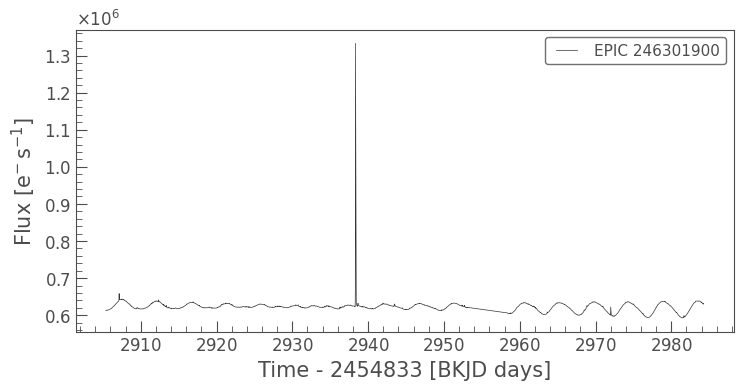

In [25]:
lc_inj.plot()